# Mapping single-cell profile onto spatial profile

Tangram is a method for mapping single-cell (or single-nucleus) gene expression data onto spatial gene expression data. Tangram takes as input a single-cell dataset and a spatial dataset, collected from the same anatomical region/tissue type. Via integration, Tangram creates new spatial data by aligning the scRNAseq profiles in space. This allows to project every annotation in the scRNAseq (e.g. cell types, program usage) on space.

The most common application of Tangram is to resolve cell types in space. Another usage is to correct gene expression from spatial data: as scRNA-seq data are less prone to dropout than (e.g.) Visium or Slide-seq, the “new” spatial data generated by Tangram resolve many more genes. As a result, we can visualize program usage in space, which can be used for ligand-receptor pair discovery or, more generally, cell-cell communication mechanisms. If cell segmentation is available, Tangram can be also used for deconvolution of spatial data. If your single cell are multimodal, Tangram can be used to spatially resolve other modalities, such as chromatin accessibility.

Biancalani, T., Scalia, G., Buffoni, L. et al. Deep learning and alignment of spatially resolved single-cell transcriptomes with Tangram. Nat Methods 18, 1352–1362 (2021). https://doi.org/10.1038/s41592-021-01264-7

![img](https://tangram-sc.readthedocs.io/en/latest/_images/tangram_overview.png)

In [1]:
import omicverse as ov
#print(f"omicverse version: {ov.__version__}")
import scanpy as sc
#print(f"scanpy version: {sc.__version__}")
ov.plot_set(font_path='Arial')
!date

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ [GPU 1] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.

2025年 08月 05日 星期二 00:16:14 CST


## Prepared scRNA-seq

Published scRNA-seq datasets of lymph nodes have typically lacked an adequate representation of germinal centre-associated immune cell populations due to age of patient donors. We, therefore, include scRNA-seq datasets spanning lymph nodes, spleen and tonsils in our single-cell reference to ensure that we captured the full diversity of immune cell states likely to exist in the spatial transcriptomic dataset.

Here we download this dataset, import into anndata and change variable names to ENSEMBL gene identifiers.

Link: https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad

<Axes: title={'center': 'Subset'}, xlabel='X_umap1', ylabel='X_umap2'>

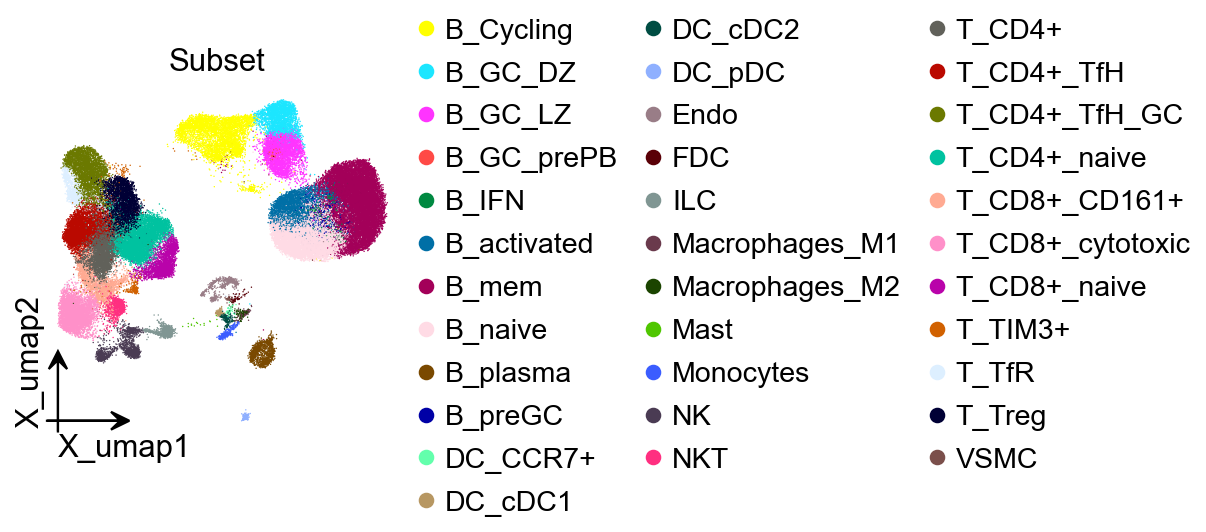

In [2]:
adata_sc=ov.read('data/sc.h5ad')
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ov.utils.embedding(
    adata_sc,
    basis="X_umap",
    color=['Subset'],
    title='Subset',
    frameon='small',
    #ncols=1,
    wspace=0.65,
    #palette=ov.utils.pyomic_palette()[11:],
    show=False,
    ax=ax
)

For data quality control and preprocessing, we can easily use omicverse's own preprocessing functions to do so

In [3]:
print("RAW",adata_sc.X.max())
adata_sc=ov.pp.preprocess(adata_sc,mode='shiftlog|pearson',n_HVGs=3000,target_sum=1e4)
adata_sc.raw = adata_sc
adata_sc = adata_sc[:, adata_sc.var.highly_variable_features]
print("Normalize",adata_sc.X.max())

RAW 13718.0
Begin robust gene identification


After filtration, 10237/10237 genes are kept.     Among 10237 genes, 9838 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell
The following highly-expressed genes are not considered during normalization factor computation:
['IGKC', 'FDCSP', 'FABP4', 'HBB', 'MALAT1', 'IGHG2', 'IGHA1', 'IGHG1', 'IGHG3', 'IGHM', 'HBA2', 'IGLC2', 'IGLC3', 'IGLC7', 'IGH_VDJsum', 'IGK_VDJsum', 'IGL_VDJsum']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 12.090657472610474 seconds.
End of size normalization: shiftlog and HVGs s

## Prepared stRNA-seq

First let’s read spatial Visium data from 10X Space Ranger output. Here we use lymph node data generated by 10X and presented in [Kleshchevnikov et al (section 4, Fig 4)](https://www.biorxiv.org/content/10.1101/2020.11.15.378125v1). This dataset can be conveniently downloaded and imported using scanpy. See [this tutorial](https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_short_demo.html) for a more extensive and practical example of data loading (multiple visium samples).

In [4]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.obs['sample'] = list(adata.uns['spatial'].keys())[0]
adata.var_names_make_unique()

reading data/V1_Human_Lymph_Node/filtered_feature_bc_matrix.h5
 (0:00:01)


We used the same pre-processing steps as for scRNA-seq

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    We introduced the spatial special svg calculation module prost in omicverse versions greater than `1.6.0` to replace scanpy's HVGs, if you want to use scanpy's HVGs you can set mode=`scanpy` in `ov.space.svg` or use the following code.
  </p>
</div>

```python
#adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,target_sum=1e4)
#adata.raw = adata
#adata = adata[:, adata.var.highly_variable_features]
```

In [5]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:,adata.var['total_counts']>100]
adata=ov.space.svg(adata,mode='prost',n_svgs=3000,target_sum=1e4,platform="visium",)
adata.raw = adata
adata = adata[:, adata.var.space_variable_features]
adata_sp=adata.copy()
adata_sp


Filtering genes ...

Calculating image index 1D:

Normalize each geneing...

Gaussian filtering...


100%|██████████| 11792/11792 [00:49<00:00, 240.12it/s]



Binary segmentation for each gene:


100%|██████████| 11792/11792 [00:53<00:00, 218.67it/s]



Spliting subregions for each gene:


100%|██████████| 11792/11792 [00:49<00:00, 238.88it/s]



Computing PROST Index for each gene:


100%|██████████| 11792/11792 [00:09<00:00, 1282.56it/s]


PROST Index calculation completed !!
PI calculation is done!
normalizing counts per cell


    finished (0:00:00)
normalization and log1p are done!


AnnData object with n_obs × n_vars = 4035 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'image_idx_1d'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'SEP', 'SIG', 'PI', 'space_variable_features', 'highly_variable'
    uns: 'spatial', 'grid_size', 'locates', 'nor_counts', 'gau_fea', 'binary_image', 'subregions', 'del_index', 'log1p', 'REFERENCE_MANU'
    obsm: 'spatial'
    layers: 'counts'

## Tangram model

Tangram is a Python package, written in PyTorch and based on scanpy, for mapping single-cell (or single-nucleus) gene expression data onto spatial gene expression data. The single-cell dataset and the spatial dataset should be collected from the same anatomical region/tissue type, ideally from a biological replicate, and need to share a set of genes. 

We can use `omicverse.space.Tangram` to apply the Tangram model.

In [7]:
tg=ov.space.Tangram(adata_sc,adata_sp,clusters='Subset')

tangram have been install version: 1.0.4
ranking genes
    finished: added to `.uns['Subset_rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)
...Calculate The Number of Markers: 1290


INFO:root:517 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:941 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


...Model prepared successfully


The function maps iteratively as specified by num_epochs. We typically interrupt mapping after the score plateaus. 
- The score measures the similarity between the gene expression of the mapped cells vs spatial data on the training genes. 
- The default mapping mode is mode=`cells`, which is recommended to run on a GPU. 
- Alternatively, one can specify mode=`clusters` which averages the single cells beloning to the same cluster (pass annotations via cluster_label). This is faster, and is our chioce when scRNAseq and spatial data come from different specimens. 
- If you wish to run Tangram with a GPU, set device=`cuda:0` otherwise use the set device=`cpu`. 
- density_prior specifies the cell density within each spatial voxel. Use uniform if the spatial voxels are at single cell resolution (ie MERFISH). The default value, rna_count_based, assumes that cell density is proportional to the number of RNA molecules

In [8]:
tg.train(mode="clusters",num_epochs=500,device="cuda:0")

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 517 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.720, KL reg: 0.059
Score: 0.843, KL reg: 0.000
Score: 0.844, KL reg: 0.000
Score: 0.844, KL reg: 0.000
Score: 0.844, KL reg: 0.000


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


...Model train successfully


We can use `tg.cell2location()` to get the cell location in spatial spots.

In [9]:
adata_plot=tg.cell2location()
adata_plot.obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'image_idx_1d', 'uniform_density', 'rna_count_based_density', 'B_GC_LZ',
       'B_preGC', 'FDC', 'B_GC_prePB', 'T_CD8+_naive', 'Monocytes', 'B_naive',
       'Macrophages_M1', 'ILC', 'B_Cycling', 'T_TIM3+', 'DC_cDC1', 'T_CD4+',
       'B_plasma', 'NKT', 'DC_cDC2', 'DC_pDC', 'DC_CCR7+', 'NK', 'VSMC',
       'T_Treg', 'T_CD8+_CD161+', 'B_activated', 'T_CD8+_cytotoxic',
       'T_CD4+_TfH', 'B_mem', 'Macrophages_M2', 'T_CD4+_naive', 'Mast',
       'B_IFN', 'B_GC_DZ', 'Endo', 'T_CD4+_TfH_GC', 'T_TfR'],
      dtype='object')

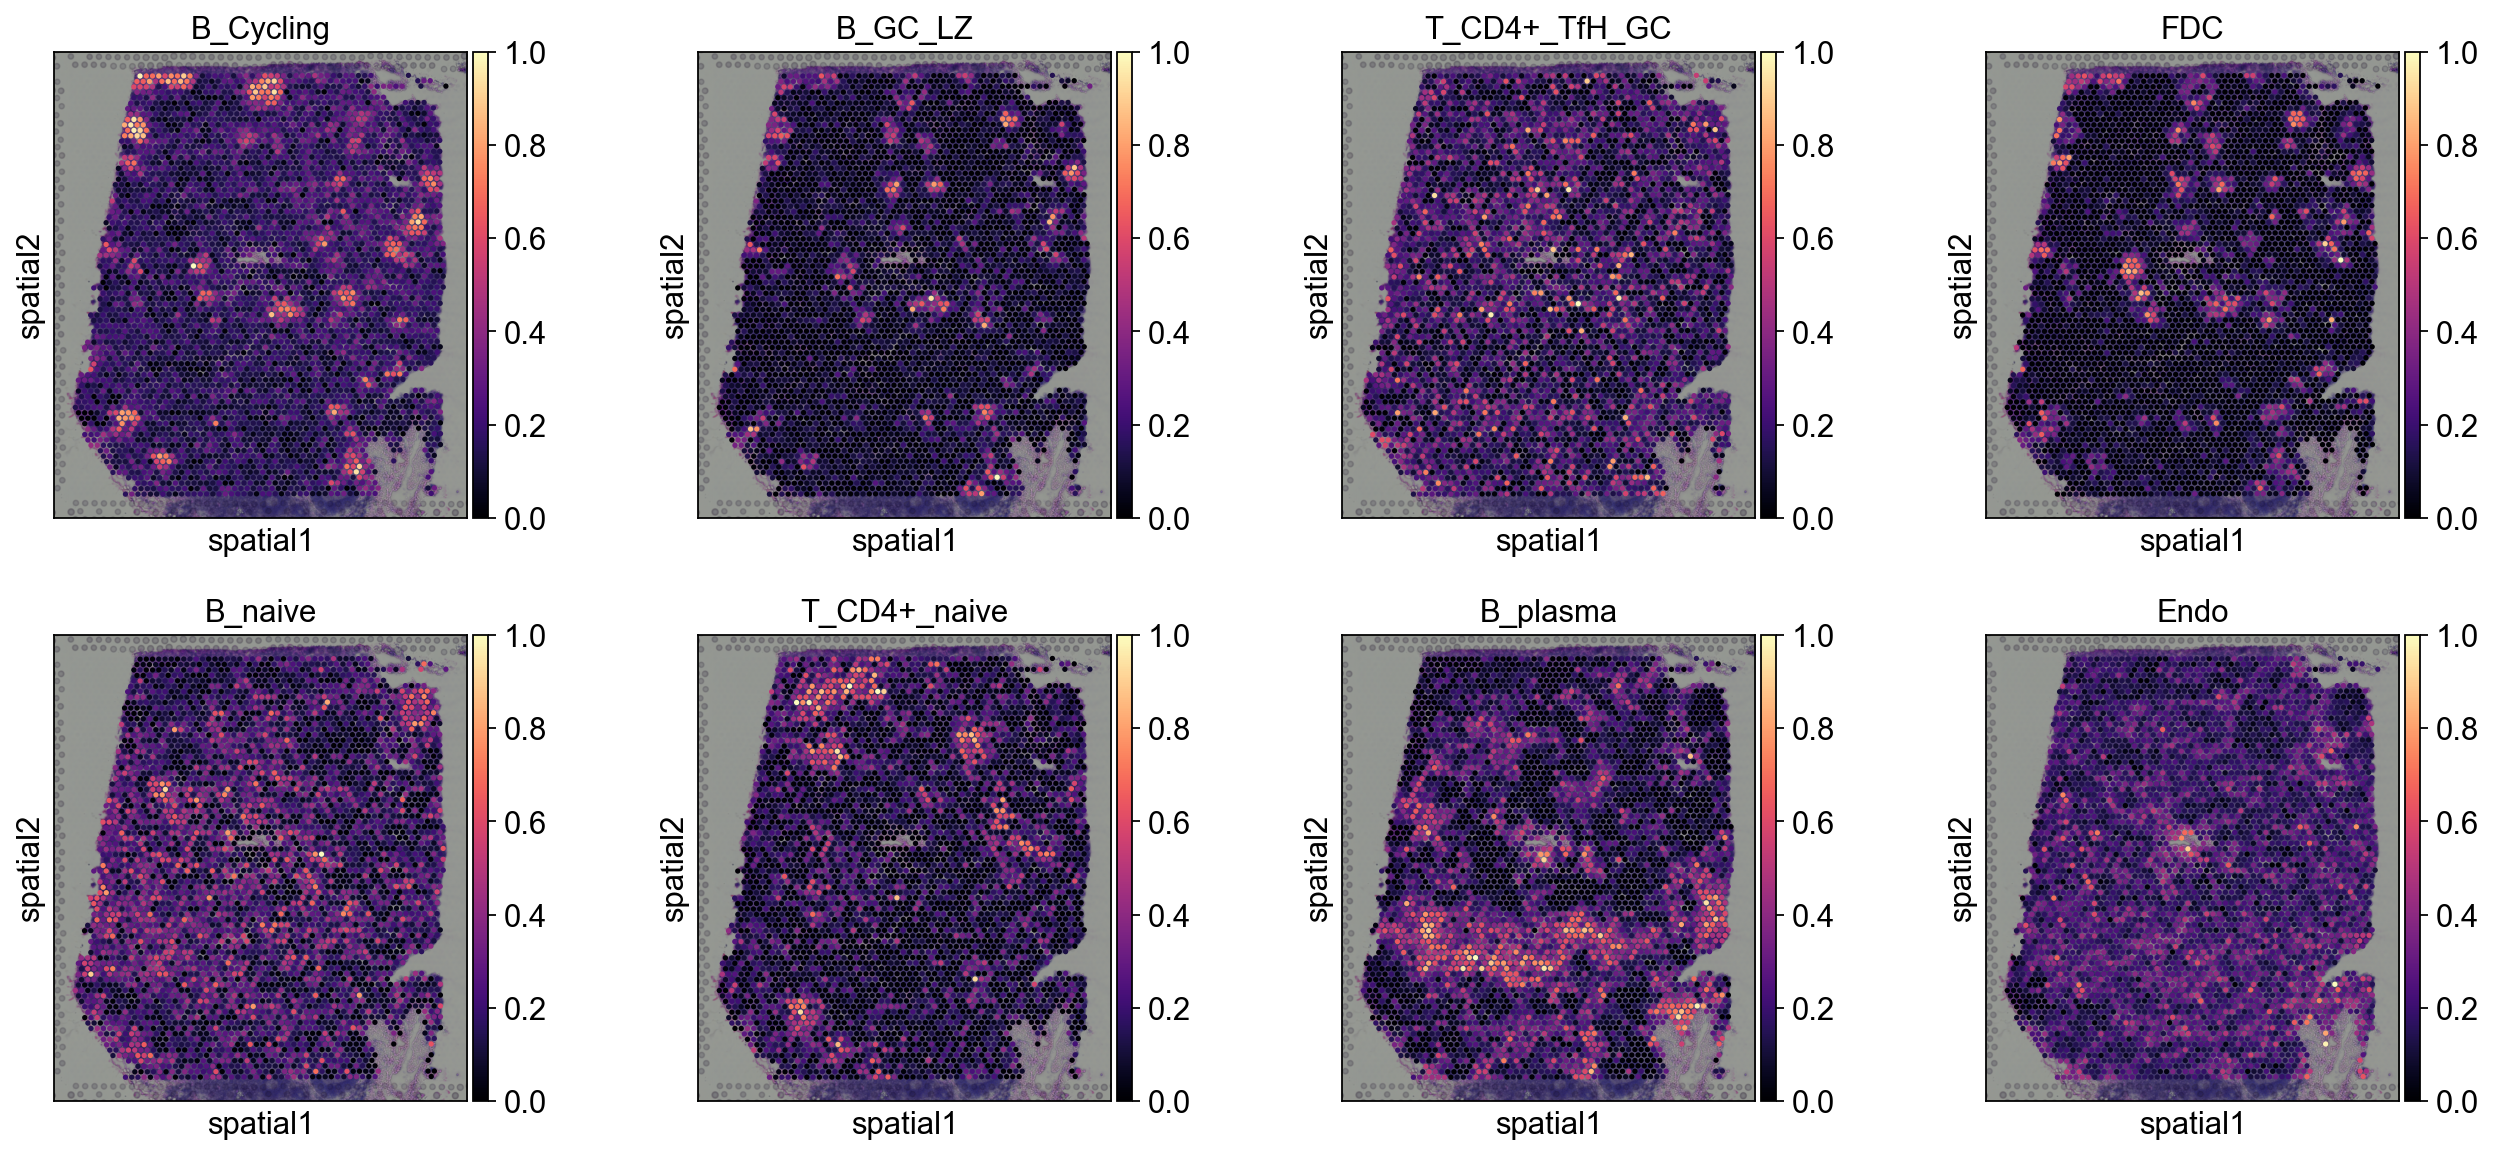

In [10]:
annotation_list=['B_Cycling', 'B_GC_LZ', 'T_CD4+_TfH_GC', 'FDC',
                         'B_naive', 'T_CD4+_naive', 'B_plasma', 'Endo']

sc.pl.spatial(adata_plot, cmap='magma',
                  # show first 8 cell types
                  color=annotation_list,
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  #vmin=0, vmax='p99.2'
                 )

In [11]:
color_dict=dict(zip(adata_sc.obs['Subset'].cat.categories,
                   adata_sc.uns['Subset_colors']))

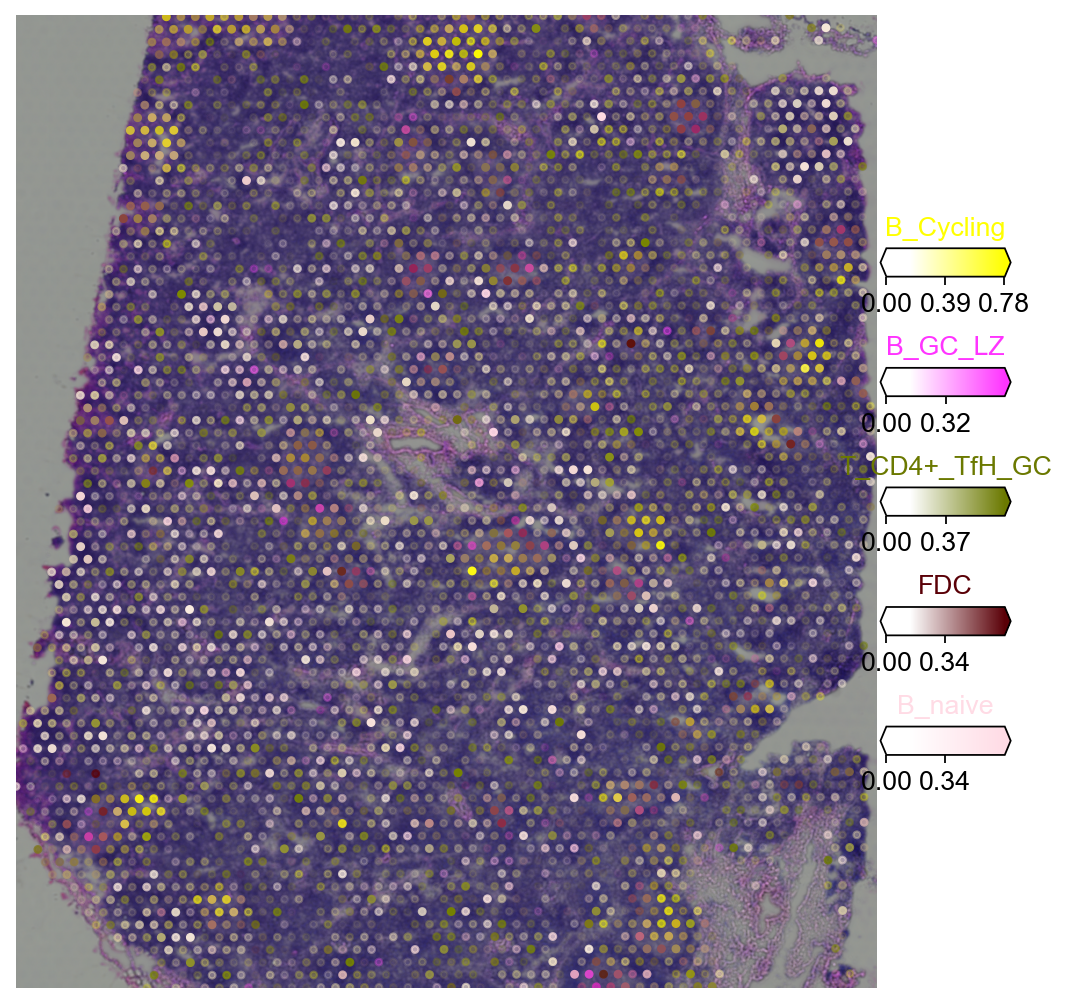

In [12]:
import matplotlib as mpl
clust_labels = annotation_list[:5]
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

with mpl.rc_context({'figure.figsize': (8, 8),'axes.grid': False}):
    fig = ov.pl.plot_spatial(
        adata=adata_plot,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=3,
        reorder_cmap = [#0,
            1,2,3,4,6], #['yellow', 'orange', 'blue', 'green', 'purple', 'grey', 'white'],
        colorbar_position='right',
        palette=color_dict
    )
    